# Boosting


In [1]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Сгенерируем синтетические данные:

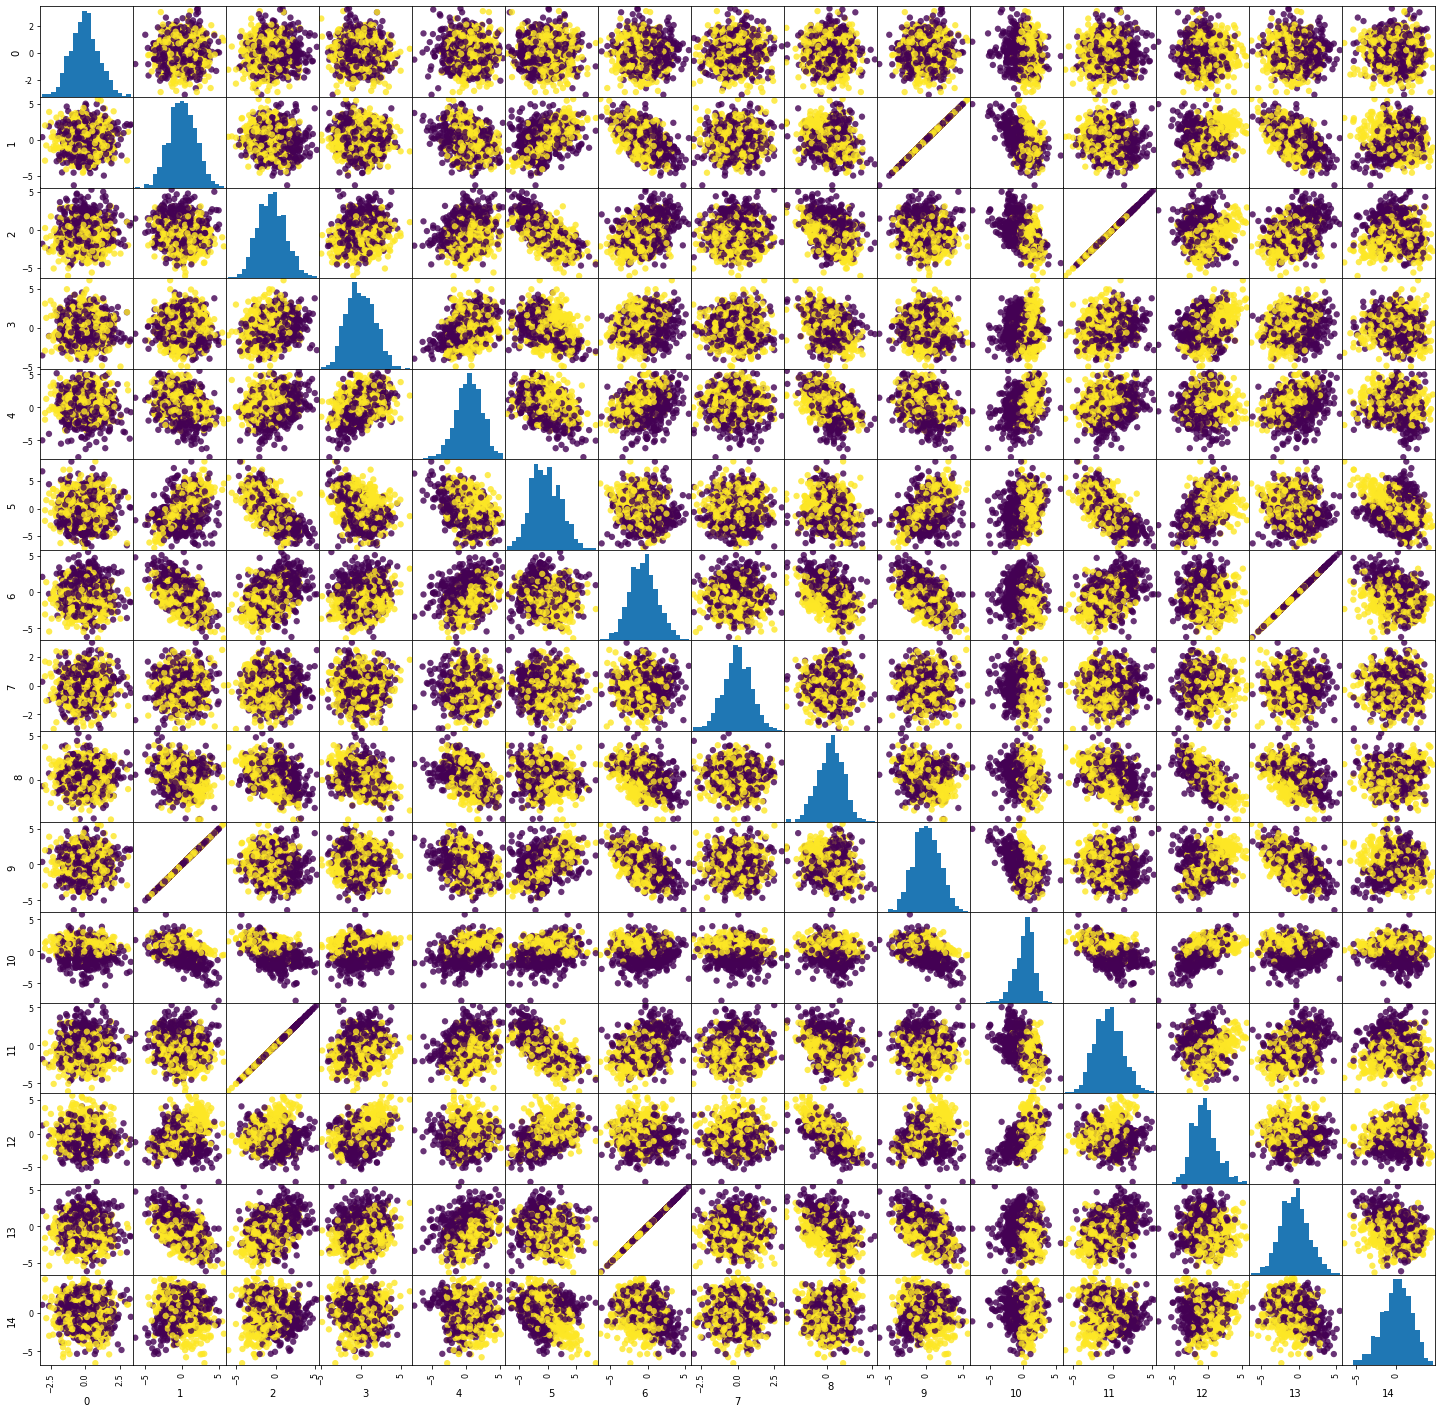

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

x, y = make_classification(n_samples=1000, n_features=15, n_informative=7, 
                           n_redundant=3, n_repeated=3, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=0)

features = pd.DataFrame(x)
targets = pd.Series(y)

scat_mtrx = pd.plotting.scatter_matrix(features, c=targets, figsize=(25, 25), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Заранее определим параметры алгоритма:
- бинарная классификация - 'objective': 'binary:logistic'
- глубина деревьев - 'max_depth': 3
- шаг градиентного спуска (скорость обучения) - 'eta': 0.1
- количество итераций бустинга - num_rounds = 60

In [3]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

Обучим модель, передав в метод вышеопределенные словарь параметров, тренировочные данные в формате DMatrix и число итераций, и добавив *evals* для отслеживания качества модели на каждой итерации обучения:

In [4]:
evals = [(dtest, 'test'), (dtrain, 'train')]

xgb_model = xgb.train(params, dtrain, num_rounds, evals)

[11:12:15] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.65427	train-logloss:0.64921
[1]	test-logloss:0.62306	train-logloss:0.61093
[2]	test-logloss:0.59618	train-logloss:0.58040
[3]	test-logloss:0.57322	train-logloss:0.55415
[4]	test-logloss:0.55585	train-logloss:0.53120
[5]	test-logloss:0.53811	train-logloss:0.51048
[6]	test-logloss:0.52398	train-logloss:0.49287
[7]	test-logloss:0.50930	train-logloss:0.47611
[8]	test-logloss:0.49858	train-logloss:0.46116
[9]	test-logloss:0.48791	train-logloss:0.44919
[10]	test-logloss:0.47926	train-logloss:0.43715
[11]	test-logloss:0.47103	train-logloss:0.42839
[12]	test-logloss:0.46187	train-logloss:0.41679
[13]	test-logloss:0.45665	train-logloss:0.40829
[14]	test-logloss:0.45267	train-logloss:0.40148
[15]	t

Определим важность признаков (с помощью F-score):

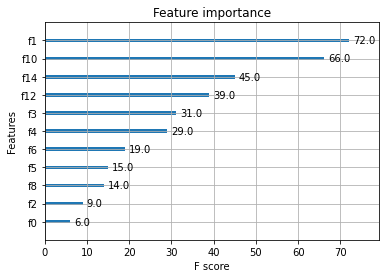

In [5]:
xgb.plot_importance(xgb_model);

Теперь сгенерируем несбалансированную выборку:

In [6]:
x, y = make_classification(n_samples=1000, n_features=7, n_informative=3, n_redundant=3, 
                           n_classes=2, weights=[.9, .1], random_state=20)

print(f'There are {sum(y)} positive instances')

There are 104 positive instances


Разобьём выборку на тренировочную и тестовую:

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=0)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

Зададим параметры для алгоритма и количество итераций:

In [8]:
params = {'objective': 'binary:logistic', 
          'max_depth': 1, 
          'silent': 1, 
          'eta': 1}

num_rounds = 30

Обучим модель и получим предсказания для тестовых данных в виде бинарной матрицы:

In [9]:
import numpy as np

xgb_model = xgb.train(params, dtrain, num_rounds)

preds = xgb_model.predict(dtest)

preds_bool = np.asarray([True if el>0.5 else False for el in preds])
preds_bool

[11:12:30] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:30] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Выведем матрицу ошибок, точность и полноту для полученных предсказаний:

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [11]:
print(confusion_matrix(preds_bool, y_test), '\n')

print(precision_score(y_test, preds_bool), '\n')

print(recall_score(y_test, preds_bool))

[[265  22]
 [  4   9]] 

0.6923076923076923 

0.2903225806451613


Заметно, что полнота гораздо ниже точности, т.е. алгоритм плохо распознает объекты класса, который представлен меньшим количеством экземпляров.

Теперь зададим вручную веса для экземпляров классов.

In [12]:
import numpy as np

weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

Повторим действия из предыдущего блока, но вручную добавим веса тренировочным данным:

In [13]:
dtrain = xgb.DMatrix(X_train, y_train, weight=weights)
dtest = xgb.DMatrix(X_test, y_test)

xgb_model2 = xgb.train(params, dtrain, num_rounds)

preds2 = xgb_model2.predict(dtest)

preds2_bool = np.asarray([True if el>0.5 else False for el in preds2])

print(confusion_matrix(preds2_bool, y_test), '\n')

print(precision_score(y_test, preds2_bool), '\n')

print(recall_score(y_test, preds2_bool))

[11:12:44] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:44] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[248  11]
 [ 21  20]] 

0.4878048780487805 

0.6451612903225806


Видно, что значение полноты увеличилось, но при этом точность уменьшилась. Попробуем в параметры обучения добавить scale_pos_weight.


Снова создадим объекты DMatrix (без весов):

In [14]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

Добавим параметр scale_pos_weight как соотношение числа объектов двух классов (но в данном случае для того, чтобы получить примерно одинаковые значения точности и полноты, поделим это соотношение на 3):

In [15]:
y_ratio = sum(y==0) / sum(y==1)

params = {'objective': 'binary:logistic',
          'max_depth': 1,
          'silent': 1,
          'eta': 1,
          'scale_pos_weight': y_ratio/3}

num_rounds = 30

Обучим модель, получим её предсказания для тестовой выборки, выведем матрицу ошибок, точность и полноту:

In [16]:
xgb_model3 = xgb.train(params, dtrain, num_rounds)

preds3 = xgb_model3.predict(dtest)

preds3_bool = np.asarray([True if el>0.5 else False for el in preds3])

print(confusion_matrix(preds3_bool, y_test), '\n')

print(precision_score(y_test, preds3_bool), '\n')

print(recall_score(y_test, preds3_bool))

[11:13:01] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:01] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[258  15]
 [ 11  16]] 

0.5925925925925926 

0.5161290322580645


# Stacking

Написание своего алгоритма стекинга

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [18]:
def stacking(models, meta_alg, data_train, data_test, targets_train, targets_test=None, random_state=None, test_size=None, cv=5):
    if test_size is None:
        meta_mtrx = np.empty((data_train.shape[0], len(models)))                     # определение матрицы метапризнаков

        for n, model in enumerate(models):                                           # Цикл для заполнения meta_mtrx:
            current_model = model.fit(data_train, targets_train)                     # обучение каждого алгоритма на полном тренировочном датасете
            meta_mtrx[:,n] = cross_val_predict(current_model, data_train, targets_train, cv=cv, method='predict') # заполнение каждого столбца метапризнаков (для
                                                                                                                  # каждой модели) с помощью функции cross_val_predict
        meta_alg = XGBClassifier(n_esimators=40)        
        meta_model = meta_alg.fit(meta_mtrx, targets_train)                          # обучение мета алгоритма на матрице метапризнаков

        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))                 # определение матрицы метапризнаков для тестового набора данных

        for n, model in enumerate(models):                                           # Цикл для заполнения meta_mtrx_test предсказаниями базовых моделей на
            current_model = model.fit(data_train, targets_train)                     # тестовых данных data_test
            meta_mtrx_test[:,n] = current_model.predict(data_test)

        meta_predict = meta_alg.predict(meta_mtrx_test)                              # Предсказания мета-алгоритма для значений матрицы meta_matrix_test

        if targets_test is not None:                                                 # Проверка существования данных targets_test для проверки качества работы 
            output = (f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')  # модели на тестовых данных

        return(output, meta_predict)

    elif test_size > 0 and test_size < 1:
        data_train_data, data_train_data_valid, data_train_targets, data_train_targets_valid = train_test_split(data_train,
                                                                                              targets_train,
                                                                                              test_size=test_size,
                                                                                              random_state=0)

        meta_mtrx = np.empty((data_train_data_valid.shape[0], len(models)))

        for n, model in enumerate(models):                                           # Цикл для заполнения матрицы meta_mtrx значениями предсказаний моделей на
            current_model = model.fit(data_train_data, data_train_targets)           # валидационных данных
            meta_mtrx[:,n] = current_model.predict(data_train_data_valid)

        meta_alg = XGBClassifier(n_esimators=40)
        meta_model = meta_alg.fit(meta_mtrx, data_train_targets_valid)               # Обучение мета-алгоритма на значениях из meta_mtrx и целевой переменной
                                                                                     # валидационных данных
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))

        for n, model in enumerate(models):                                           # Цикл для заполнения матрицы meta_mtrx_test предсказаниями базовых моделей
            current_model = model.fit(data_train, targets_train)                     # на тестовых данных data_test
            meta_mtrx_test[:,n] = current_model.predict(data_test)

        meta_predict = meta_alg.predict(meta_mtrx_test)                              # Предсказания мета-алгоритма для значений матрицы meta_mtrx_test

        if targets_test is not None:                                                 # Проверка существования данных targets_test для проверки качества работы
           output = (f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')   # модели на тестовых данных

        return(output, meta_predict)

    else:
        raise ValueError("test_size must be between 0 and 1")

Базовая функция стекинга готова. Проверим её работоспособность на датасете Titatic в 3-х случаях:

1. Вызвать исключение "test_size must be between 0 and 1".

2. Установить test_size=0.3; вывести AUC и массив полученных предсказаний.

3. Оставить test_size=None; вывести AUC и массив полученных предсказаний.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


titanic = pd.read_csv('titanic.csv')
targets = titanic.Survived
data = titanic.drop(columns='Survived')

x_train, x_test, y_train, y_test = train_test_split(data,
                                                    targets,
                                                    train_size=0.8,
                                                    random_state=0)

knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(random_state=0)
svc = SVC(random_state=0)

models = [knn, lr, svc]

meta = XGBClassifier(n_estimators=40)

In [20]:
stacking(models, meta, x_train, x_test, y_train, y_test, test_size=2)

ValueError: test_size must be between 0 and 1

In [21]:
stacking(models, meta, x_train, x_test, y_train, y_test, test_size=0.3)

[11:13:31] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:576: 
Parameters: { "n_esimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:31] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


('Stacking AUC: 0.8121870882740447',
 array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0], dtype=int64))

In [22]:
stacking(models, meta, x_train, x_test, y_train, y_test, test_size=None)

[11:13:33] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:576: 
Parameters: { "n_esimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:13:33] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


('Stacking AUC: 0.8040843214756257',
 array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0], dtype=int64))